### 01 - Data Loading, Visualization, and Preprocessing

This notebook serves as the initial data exploration and preprocessing step. The goal is to:

1. Confirm successful reading of FastMRI HDF5 files and k-space extraction.
2. Inspect the structure and distribution of the fastmri+ clinical labels.
3. Prototype the entire data flow: Generate the undersampling mask, apply it to the k-space, and visualize the resulting Zero-Filled IFFT (Artifact Baseline / Pipeline A U-Net Input) against the Fully Sampled IFFT (Ground Truth).

NOTE on Data Type: For simplicity and to focus the project on the core comparison of reconstruction methods, we are using the single-coil knee data. This choice bypasses the need for complex multi-coil combination techniques (like Sum-of-Squares) which would be an extra, non-essential step for this demonstration.

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import warnings
from pathlib import Path
import fastmri
from fastmri.data import transforms as T

data_root = Path('../data/raw/singlecoil_val')
label_path = Path('../data/labels')
list_all_files = Path('../data/labels''/knee_file_list.csv')
list_labeled_files = Path('../data/labels/knee.csv')

np.random.seed(42)

# to rewrite splits
save_splits = False

#### 1.1. HDF5 File Inspection and K-Space Loading

We start with exploring the data format

In [2]:
local_files = [f.name for f in data_root.glob('*.h5')]

sample = np.random.choice(local_files)
print(f"Using sample file: {sample}")
sample_data = h5py.File(data_root/sample)
print("Data keys: ",sample_data.keys())
print("Data attributes: ", dict(sample_data.attrs))
print(sample_data["kspace"])

Using sample file: file1001159.h5
Data keys:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>
Data attributes:  {'acquisition': 'CORPDFS_FBK', 'max': np.float64(0.00012701124478474129), 'norm': np.float64(0.03614206476365185), 'patient_id': 'fb482aa089132e9b10f7c9221620a682c0d9c34b15ca60a9982d132ea15e4e02'}
<HDF5 dataset "kspace": shape (30, 640, 372), type "<c8">


The file contains:
- kspace: The raw, complex frequency data
- ismrmrd_header: Acquisition metadata in XML
- reconstruction_rss: The standard Sum-of-Squares magnitude image (reconstructed by the scanner/pipeline, common benchmark).
- reconstruction_esc: Another form of reconstruction, specific to certain techniques (e.g., Espresso SENSE Coil), which is common in specialized fastMRI datasets.
As well as a number of attributes:
- acqusition: The specific pulse sequence name
- max: The maximum absolute value of the raw k-space data for this specific file
- norm: A factor is related to the overall magnitude and normalization used during the acquisition/reconstruction process
- patient_id: A anonymized identifier.

This file contains 30 image slices with 640x372complex values of k. Let's have a look at k-space and real space images.

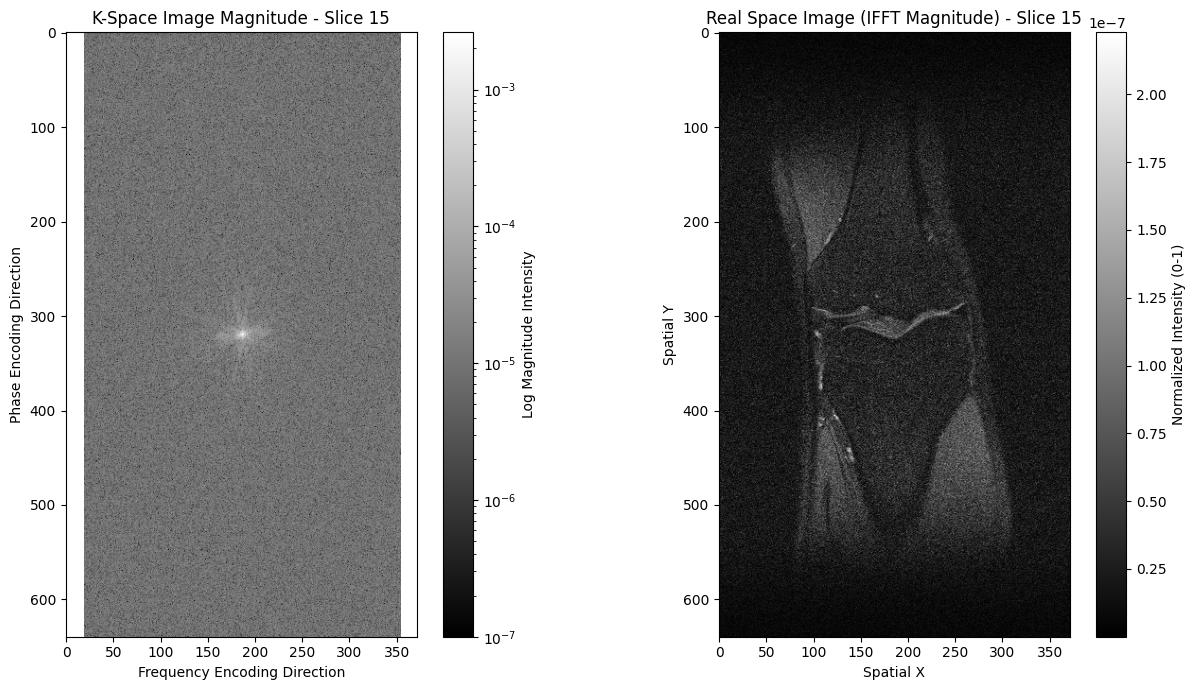

In [3]:
kspace = sample_data["kspace"][:] # get the numpy array from hdf5 file
slice_id = int(sample_data["kspace"].shape[0]/2)
kspace_slice = kspace[slice_id]

def plot_slice(kspace_slice, slice_id = 17):
    
    # calculate abs from complex values in k space for plotting
    magnitude_kspace = np.abs(kspace_slice)
    # calculate ifft and abs again
    image_raw = np.fft.ifftn(kspace_slice)
    magnitude_rspace  = np.abs(np.fft.fftshift(image_raw))

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
                
    # Left Plot: K-Space (Frequency Domain)
    im1 = axes[0].imshow(magnitude_kspace, cmap='gray',  norm=LogNorm(vmin=1e-7, vmax=magnitude_kspace.max()))
    axes[0].set_title(f"K-Space Image Magnitude - Slice {slice_id}")
    axes[0].set_xlabel("Frequency Encoding Direction")
    axes[0].set_ylabel("Phase Encoding Direction")
    axes[0].axis('on')
    fig.colorbar(im1, ax=axes[0], label="Log Magnitude Intensity", fraction=0.046, pad=0.04)

    #Right Plot: Final Cropped Image (Spatial Domain / ML Input)
    im2 = axes[1].imshow(magnitude_rspace, cmap='gray')
    axes[1].set_title(f"Real Space Image (IFFT Magnitude) - Slice {slice_id}")
    axes[1].set_xlabel("Spatial X")
    axes[1].set_ylabel("Spatial Y")
    axes[1].axis('on')
    fig.colorbar(im2, ax=axes[1], label="Normalized Intensity (0-1)", fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

plot_slice(kspace_slice=kspace_slice, slice_id=slice_id)

#### 1.2 Cartesian Undersampling Mask

We will now create a mask to simulate undersampling for phase-encoding and see what effects it has on the real space image. This mask simulates Cartesian accelerated MRI and is structured for effective deep learning reconstruction:

-  Fully Sampled Center (ACR): Captures essential low-frequency data (image contrast) needed for successful reconstruction and is the basis for calibration algorithms  (center percentage to keep is a parameter).
-  Random Undersampling: Skips high-frequency lines (Accelerating factor AF as parameter). The randomness converts severe aliasing artifacts into incoherent, noise-like patterns, which are significantly easier for the U-Net model to suppress.

In [4]:
def generate_undersampling_mask(shape, AF=4, center_fraction = 0.05, power = 4.0):
    """
    Generates a 2D Cartesian undersampling mask.

    The mask is 1D in the frequency-encoding direction (width) and tiled 
    across the phase-encoding direction (height) and uses variable density

    Args:
        shape: shape of a k-space slice
        AF (int): Acceleration factor
        center_fraction (float): fraction of low frequencies fully sampled
        power: power in density equation

    Returns:
        np.ndarray: A 2D boolean mask of shape

    """

    width = shape[1]
    center_lines_abs = int(width * center_fraction)
    center_lines = center_lines_abs if center_lines_abs % 2 == 0 else center_lines_abs + 1

    x = np.linspace(-1, 1, width)
    probs = 1.0 / (1.0 + (np.abs(x) ** power) * AF)

    mask = np.random.rand(width) < probs

    #Fully sample the center lines (Autocalibration Region - ACR)
    center_start = (width - center_lines) // 2
    mask[center_start:center_start + center_lines] = True
        
    # Create the 2D mask by tiling it across the phase-encoding dimension (H)
    mask_2d = np.tile(mask, (shape[0], 1))

    return mask_2d

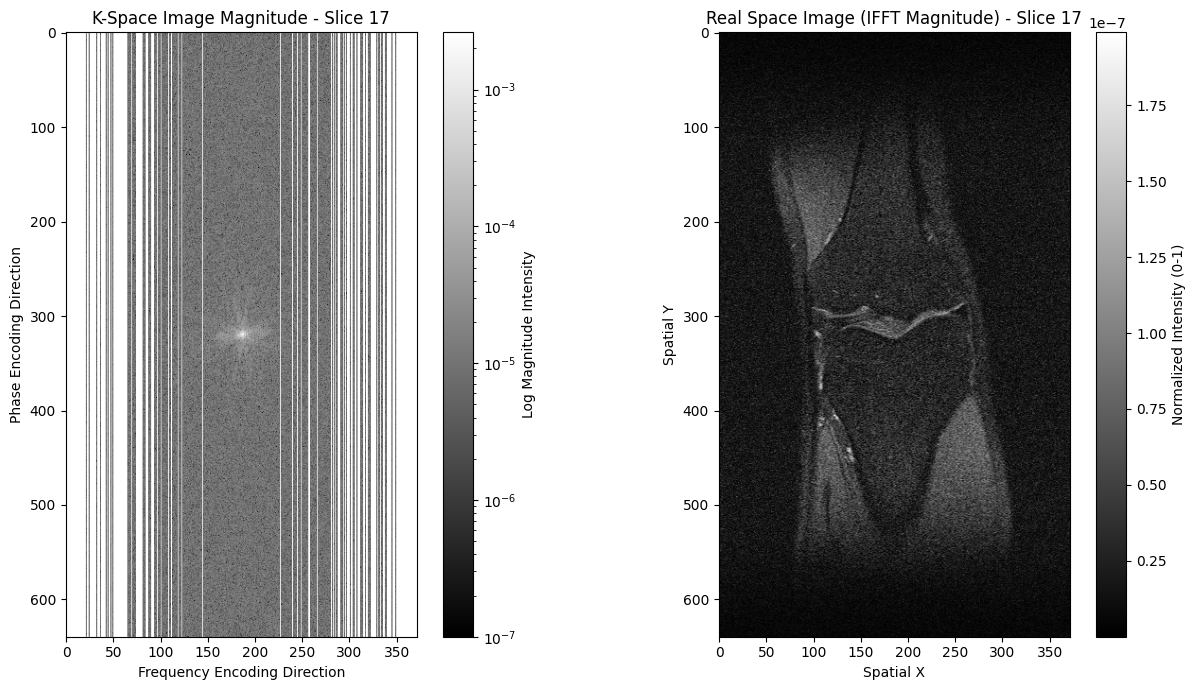

In [5]:
mask_2d = generate_undersampling_mask(kspace_slice.shape, power = 4, AF = 10, center_fraction=0.06)
            
undersampled_kspace = kspace_slice * mask_2d
plot_slice(kspace_slice=undersampled_kspace, slice_id=17)


#### 1.3 Data Splitting for Binary Classification

For the classification task, we require both reconstructed images and the associated clinical labels.As for demo we limit ourselves with val set (199 files), first we need to check which clinical labels are presented in this limited dataset.

In [6]:
df_labels = pd.read_csv(list_labeled_files)
local_files_stem = [f.removesuffix('.h5') for f in local_files]
df_local_labels = df_labels[df_labels['file'].isin(local_files_stem)].reset_index(drop=True)
display(df_local_labels)
df_local_labels.label.value_counts()

,file,slice,study_level,x,y,width,height,label
0,file1000000,9,No,99.0,64.0,57.0,81.0,Joint Effusion
1,file1000000,10,No,87.0,52.0,56.0,108.0,Joint Effusion
2,file1000000,11,No,79.0,53.0,57.0,109.0,Joint Effusion
3,file1000000,12,No,76.0,57.0,57.0,115.0,Joint Effusion
4,file1000000,13,No,137.0,163.0,17.0,10.0,Cartilage - Partial Thickness loss/defect
...,...,...,...,...,...,...,...,...
2496,file1002546,14,No,200.0,26.0,70.0,125.0,Joint Effusion
2497,file1002546,15,No,212.0,33.0,58.0,124.0,Joint Effusion
2498,file1002546,16,No,225.0,39.0,47.0,123.0,Joint Effusion
2499,file1002546,22,No,216.0,184.0,20.0,9.0,Cartilage - Partial Thickness loss/defect


label
Meniscus Tear                                814
Cartilage - Partial Thickness loss/defect    491
Joint Effusion                               224
Bone-Fracture/Contusion/dislocation          185
Bone- Subchondral edema                      173
Ligament - ACL High Grade Sprain             124
Periarticular cysts                          117
Cartilage - Full Thickness loss/defect       101
Ligament - ACL Low Grade sprain               98
Ligament - MCL Low-Mod Grade Sprain           56
Soft Tissue Lesion                            35
Ligament - PCL Low-Mod grade sprain           30
Patellar Retinaculum - High grade sprain      21
LCL Complex - Low-Mod Grade Sprain            17
Displaced Meniscal Tissue                      8
Joint Bodies                                   3
Bone - Lesion                                  2
Ligament - MCL High Grade sprain               1
artifact                                       1
Name: count, dtype: int64

We will focus on the detection of Meniscus Tear (Label 1) as it is a highly relevant pathology well-represented in the dataset.

A single patient volume typically contains dozens of slices, many of which share the same clinical label. While using multiple slices per volume enriches the training data, it creates a risk of data leakage if we split the data at the slice level. Slices from the same patient are visually highly similar. Therefore, **the splitting must be performed at the patient (file) level.**

We first create a DataFrame containing only unique patients and their overall status (does the volume contain at least one Meniscus Tear slice? Yes=1, No=0). We then perform a stratified split on this patient-level DataFrame to ensure the training and validation sets have a proportional number of positive patients.

In [7]:
df_local_patients_labeled = df_local_labels[df_local_labels['label'] == "Meniscus Tear"].drop_duplicates(subset = ["file"])[["file"]]
df_local_patients_labeled['label'] = 1
local_files_stem_labeled = df_local_patients_labeled["file"].tolist()
df_local_patients_unlabeled = pd.DataFrame({
    "file": [f for f in local_files_stem if f not in local_files_stem_labeled],
    "label": 0
})
df_local_patients = pd.concat([df_local_patients_labeled, df_local_patients_unlabeled]).reset_index(drop = True)
display(df_local_patients)

from sklearn.model_selection import train_test_split 

df_train_patients, df_val_patients = train_test_split(
    df_local_patients, 
    train_size=0.8, 
    stratify=df_local_patients['label'],
    random_state=42
)
print(f"Train Patients: {len(df_train_patients)} | Val Patients: {len(df_val_patients)}")

,file,label
0,file1000007,1
1,file1000017,1
2,file1000026,1
3,file1000031,1
4,file1000041,1
...,...,...
194,file1002377,0
195,file1002380,0
196,file1002404,0
197,file1002546,0


Train Patients: 159 | Val Patients: 40


**Slice Generation Strategy**

After splitting the patient IDs, we generate the final slice manifests by applying different rules for positive and negative patients:

Positive Slices (Label 1):

    For patients in the split set with patient_label = 1, we look back at the original slice-level manifest (df_local_labels).

To prevent any single patient from dominating the positive class, we employ random, safe sampling to select a maximum of 10 actual labeled positive slices from that volume. If a patient has fewer than 10 positive slices, we take all of them.

Negative Slices (Label 0):

    For patients in the split set with patient_label = 0 (no Meniscus Tear found), we must generate placeholder slices.

    For each negative patient, we generate 10 random, unique slice indices (e.g., [15, 30, 4, 21, ...]) drawn from the full range of slice indices observed in the positive data.

    Note: We must ensure later in the data loader that these randomly selected indices actually exist in the HDF5 file for that specific patient.

In [8]:
def get_positive_slices(patient_df: pd.DataFrame, label_df: pd.DataFrame, n_max_slices: int = 10, label = "Meniscus Tear") -> pd.DataFrame:
    """
    Retrieves and safely samples up to n_max_slices of *actual labeled positive slices*
    for patients designated as positive (patient_label=1) in the split set.
    """
    positive_files = patient_df[patient_df['label'] == 1]
    # Merge to get ALL slices from the positive volumes
    positive_files_slices = label_df[label_df["label"] == label][["file", "slice"]].merge(positive_files, on='file', how='inner')
    # Apply safe random sampling per file (Handling cases with < 10 slices)
    def safe_sample_positive(group):
        N = min(n_max_slices, len(group))
        return group.sample(n=N, replace=False, random_state=42)
    return positive_files_slices.groupby('file').apply(safe_sample_positive).reset_index(drop=True)

# --- Function for Negative Slices (Label 0) ---
def create_negative_slices(patient_df: pd.DataFrame, min_slice, max_slice, n_slices: int = 10) -> pd.DataFrame:
    """
    Generates n_slices (10) of *random slice indices* for patients designated as negative (patient_label=0).
    """
    negative_files = patient_df[patient_df['label'] == 0][['file']]
    
    all_negative_slices = []
    
    # Iterate over each negative patient file
    for file_name in negative_files['file']:
        # Generate N random, unique slice indices within the overall observed range
        random_indices = np.random.choice(
            np.arange(min_slice, max_slice + 1),
            size=n_slices, 
            replace=False 
        )
        
        # Create the DataFrame for these 10 negative slices
        temp_df = pd.DataFrame({
            'file': file_name,
            'slice': random_indices,
            'label': 0
        })
        all_negative_slices.append(temp_df)

    return pd.concat(all_negative_slices, ignore_index=True)

df_positive_train_slices = get_positive_slices(df_local_patients, df_local_labels)
min_slice = df_positive_train_slices.slice.min()
max_slice = df_positive_train_slices.slice.max() - 5 # safety buffer
df_negative_train_slices = create_negative_slices(df_local_patients, max_slice=max_slice, min_slice=min_slice)
# now concat and shuffle
df_train = pd.concat([df_positive_train_slices, df_negative_train_slices]).sample(frac=1, random_state=42).reset_index(drop=True)

df_positive_val_slices = get_positive_slices(df_val_patients, df_local_labels)
df_negative_val_slices = create_negative_slices(df_val_patients, max_slice=max_slice, min_slice=min_slice)
# now concat and shuffle
df_val = pd.concat([df_positive_val_slices, df_negative_val_slices]).sample(frac=1, random_state=42).reset_index(drop=True)

C:\Users\Anna Lyamkina\AppData\Local\Temp\ipykernel_26976\2611657143.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return positive_files_slices.groupby('file').apply(safe_sample_positive).reset_index(drop=True)
C:\Users\Anna Lyamkina\AppData\Local\Temp\ipykernel_26976\2611657143.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return positive_files_slices.groupby('file').apply(safe_sample_positive).reset_i

In [ ]:
if save_splits:    
    df_train.to_csv(label_path/'train_data.csv', index=False)
    df_val.to_csv(label_path/'val_data.csv', index=False)
    print("Data splits saved!")

Data splits saved!


#### 1.4 Data Processing Workflow

1. K-space Load & Normalization: Read the single-coil, complex k-space data. Read the specific maximum intensity value from the HDF5 file attributes to be used as a global normalization factor.

2. Undersampling Simulation: Apply a stochastic Cartesian mask (based on the acceleration factor R) to the k-space data to simulate an undersampled acquisition.

3. Image Domain Conversion (IFFT):

a. Perform Inverse Fourier Transform (IFFT) on the fully sampled k-space to create the ground-truth complex image.

b. Perform IFFT on the masked k-space to create the zero-filled complex input image.

4. Preprocessing:

a. Scale both the ground-truth and input images using the global maximum intensity value.

b. Center-crop both images in the real space domain to a fixed resolution (e.g., 320×320).

5. Output Formatting: Calculate the magnitude (Real2+Imaginary2​) of the input and target complex images, and ensure the final tensor shape is [1, H, W] (Channel, Height, Width).

6. Downstream Application Mapping (Pipelines A, B, and C)

The outputs of the previous steps are utilized differently depending on the specific deep learning task. Each pipeline corresponds to a dedicated PyTorch Dataset class:

-    Pipeline A: Real-Space Reconstruction (RealSpaceReconDataset):

        Purpose: Image-to-image reconstruction (e.g., U-Net).

        Input Data: Utilizes the output of Step 5 (normalized magnitude images).

        Dataset Output Contract: (XInput​,YTarget​), both tensors of shape [1, H, W].

        Pipeline Output: reconstructed real-space image.

-    Pipeline B: K-Space Reconstruction (KSpaceReconDataset):

        Purpose: Frequency-domain reconstruction (e.g., Compressed Sensing models).

        Input Data: Utilizes the k-space data from Step 1 and Step 2 (normalized full and masked k-space).

        Dataset Output Contract: (XMasked​,YFull​), both complex tensors of shape [H, W].

        Pipeline Output: reconstructed k-space image.

-    Pipeline C: Classification (ClassificationDataset):

        Purpose: Meniscus Tear detection using transfer learning.

        Input Data: External clinical labels combined with a reconstructed image source.

        Dataset Output Contract: (XImage​,LBinary​), where X is [1, H, W] and L is [1] (Long/Integer).

        Pipeline Output: clinical label (is Meniscus tear True (1) or False (0)).

**End-to-End Flows:**

- Flow 1: A→C (Image source is the output of a Pipeline A model).

- Flow 2: B→IFFT→C (Image source is the k-space output of a Pipeline B model, converted to magnitude image).

- Flow 3:A→C trained with a combined loss for tasked-based reconstruction.
